# This notebook is to assess document sign and other conventions

In [1]:
%matplotlib widget
%config InlineBackend.figure_format = 'svg'

In [2]:
import addict
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm

import pyproj
# Global constants
GEOID = pyproj.Geod(ellps="WGS84")
KM2M = 1.0e3
M2MM = 1.0e3
RADIUS_EARTH = np.float64((GEOID.a + GEOID.b) / 2)

import celeri

plt.rcParams["text.usetex"] = (
    False  # Plotting the global model is much much faster with tex fonts turned off
)

In [3]:
# command_file_name = "./data/western_north_america/basic_command.json"
# command, segment, block, meshes, station, mogi, sar = celeri.read_data(command_file_name)
# COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
COMMAND_FILE_NAME = "../data/command/japan_command_new.json"
command = celeri.get_command(COMMAND_FILE_NAME)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)

station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)

segment["burial_depth"] = 0

sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)

2024-07-05 12:17:58.691 | INFO     | celeri.celeri:read_data:136 - Reading data files
2024-07-05 12:17:58.696 | SUCCESS  | celeri.celeri:read_data:140 - Read: ../data/segment/japan_new380_adjusted_segment.csv
2024-07-05 12:17:58.699 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/block/japan_block.csv
2024-07-05 12:17:58.700 | SUCCESS  | celeri.celeri:read_data:152 - Read: ../data/mesh/japan_mesh_parameters.json


Warning: The file contains tag data that couldn't be processed.

2024-07-05 12:17:58.730 | SUCCESS  | celeri.celeri:read_data:298 - Read: ../data/mesh/nankai.msh


Warning: The file contains tag data that couldn't be processed.

2024-07-05 12:17:58.774 | SUCCESS  | celeri.celeri:read_data:298 - Read: ../data/mesh/japan.msh


Warning: The file contains tag data that couldn't be processed.

2024-07-05 12:17:58.809 | SUCCESS  | celeri.celeri:read_data:298 - Read: ../data/mesh/sagami.msh
2024-07-05 12:17:58.813 | SUCCESS  | celeri.celeri:read_data:334 - Read: ../data/station/japan_station.csv
2024-07-05 12:17:58.815 | INFO     | celeri.celeri:read_data:349 - No mogi_file_name
2024-07-05 12:17:58.816 | INFO     | celeri.celeri:read_data:371 - No sar_file_name


# Let's plot the index for each segment to make choosing segments easier

In [ ]:
lon_min = 135
lon_max = 155
lat_min = 30
lat_max = 50

plt.figure(figsize=(12, 12))
for i in range(len(segment)):
    plt.plot(
        [segment.lon1[i], segment.lon2[i]],
        [segment.lat1[i], segment.lat2[i]],
        "-k",
        linewidth=0.5,
    )
    plt.text(
        segment.mid_lon_plate_carree[i],
        segment.mid_lat_plate_carree[i],
        str(i),
        color="r",
        clip_on=True,
        fontsize=6,
        horizontalalignment="center",
        verticalalignment="center",
    )
plt.xlim([lon_min, lon_max])
plt.ylim([lat_min, lat_max])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("segment indices")
plt.show()

In [ ]:
print(meshes[0].centroids[0, :])
print(meshes[0].lon_centroid[0])
print(meshes[0].lat_centroid[0])
print(meshes[0].z_centroid[0])

In [ ]:
# Get bottom coordinates
width_projected = 1e3*segment.locking_depth/np.tan(np.deg2rad(segment.dip))
lon1_bot = np.zeros(len(segment))
lon2_bot = np.zeros(len(segment))
lat1_bot = np.zeros(len(segment))
lat2_bot = np.zeros(len(segment))

for i in range(len(segment)):
    lon1_bot[i],lat1_bot[i], _ = GEOID.fwd(segment.lon1[i], segment.lat1[i], segment.azimuth[i]+90, width_projected[i])
    lon2_bot[i],lat2_bot[i], _ = GEOID.fwd(segment.lon2[i], segment.lat2[i], segment.azimuth[i]+90, width_projected[i])

# Check fault distances
checkdist = np.zeros_like(width_projected)
for i in range(len(segment)):
    _, _, checkdist[i] = GEOID.inv(segment.lon1[i], segment.lat1[i], lon1_bot[i], lat1_bot[i])

fig, ax = plt.subplots(figsize=(12, 12))
for i in range(len(segment)):
    array = np.array(((segment.lon1[i], segment.lat1[i]), (segment.lon2[i], segment.lat2[i]), (lon2_bot[i], lat2_bot[i]), (lon1_bot[i], lat1_bot[i])))
    plt.fill(array[:, 0], array[:, 1], "b")

plt.plot([segment.lon1, segment.lon2], [segment.lat1, segment.lat2],"-r")
plt.xlim([lon_min, lon_max])
plt.ylim([lat_min, lat_max])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Segment geometry")
plt.show()


# Let's pick a segment to visualize

In [4]:
SEGMENT_IDX = 365
segment.dip.values[SEGMENT_IDX] = 20
segment.locking_depth.values[SEGMENT_IDX] = 20
print(segment.burial_depth.values[SEGMENT_IDX])

# Make a copy of just this segment
this_segment = pd.DataFrame(columns=segment.columns, index=[0])
this_segment.loc[0] = segment.loc[SEGMENT_IDX]
this_segment.dip.values[0] = 45

this_segment_flipped = this_segment.copy(deep=True)

# Flip endpoints
this_segment_flipped.lon1 = segment.lon2.values[SEGMENT_IDX]
this_segment_flipped.lat1 = segment.lat2.values[SEGMENT_IDX]
this_segment_flipped.lon2 = segment.lon1.values[SEGMENT_IDX]
this_segment_flipped.lat2 = segment.lat1.values[SEGMENT_IDX]
this_segment_flipped.dip.values[0] = 180.-this_segment.dip[0]
print(this_segment_flipped.locking_depth[0])

0
20.0


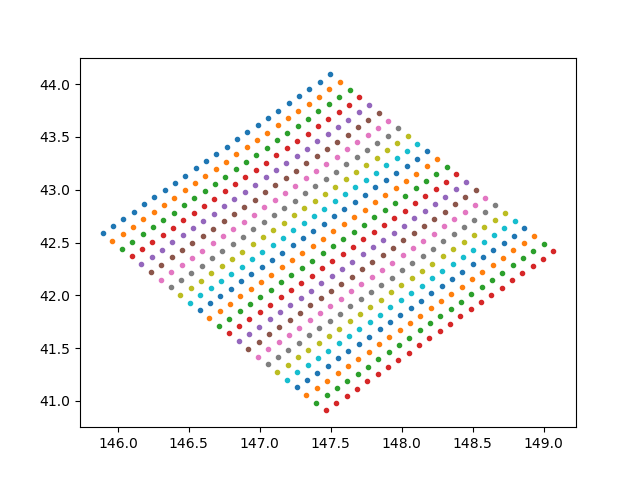

In [5]:
# Make a grid on both sides of the segment

# Coordinate vectors
x = np.arange(np.min([this_segment.lon1, this_segment.lon2])-1, np.max([this_segment.lon1, this_segment.lon2])+1, 0.1)
y = np.arange(np.min([this_segment.lat1, this_segment.lat2])-1, np.max([this_segment.lat1, this_segment.lat2])+1, 0.1)
# Meshgrid
xg, yg = np.meshgrid(x - np.mean(x), y - np.mean(y))

# Rotate meshgrid by strike
cosstrike = np.cos(np.radians(this_segment.azimuth[0]))
sinstrike = np.sin(np.radians(this_segment.azimuth[0]))
xr = xg*sinstrike + yg*cosstrike + np.mean(x)
yr = -xg*cosstrike + yg*sinstrike + np.mean(y)

# Place into station df
gridsta = pd.DataFrame(columns=["lon", "lat"])
gridsta.lon = np.reshape(xr, -1)
gridsta.lat = np.reshape(yr, -1)


# Plot to check
fig, ax = plt.subplots()
ax.plot(xr, yr, '.')
plt.show()



0.0
20000.0


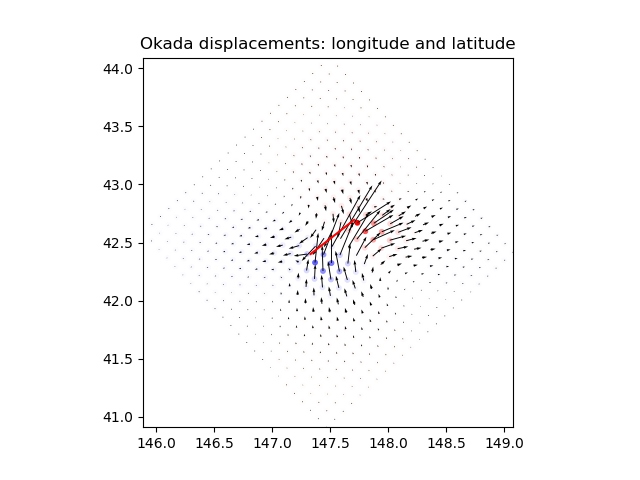

0.0
20000.0


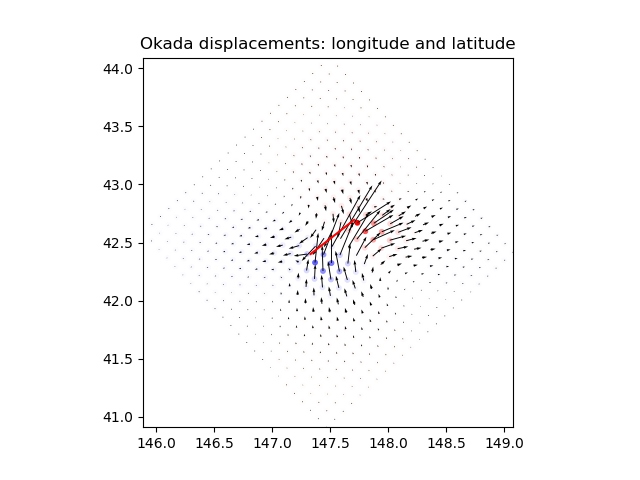

In [6]:
# strike-slip
celeri.plot_segment_displacements(
    this_segment,
    gridsta,
    command,
    segment_idx=0,
    strike_slip=1,
    dip_slip=0,
    tensile_slip=0,
    lon_min=np.min(gridsta.lon),
    lon_max=np.max(gridsta.lon),
    lat_min=np.min(gridsta.lat),
    lat_max=np.max(gridsta.lat),
    quiver_scale=1e0,
)
# strike-slip
celeri.plot_segment_displacements(
    this_segment_flipped,
    gridsta,
    command,
    segment_idx=0,
    strike_slip=1,
    dip_slip=0,
    tensile_slip=0,
    lon_min=np.min(gridsta.lon),
    lon_max=np.max(gridsta.lon),
    lat_min=np.min(gridsta.lat),
    lat_max=np.max(gridsta.lat),
    quiver_scale=1e0,
)

0.0
20000.0


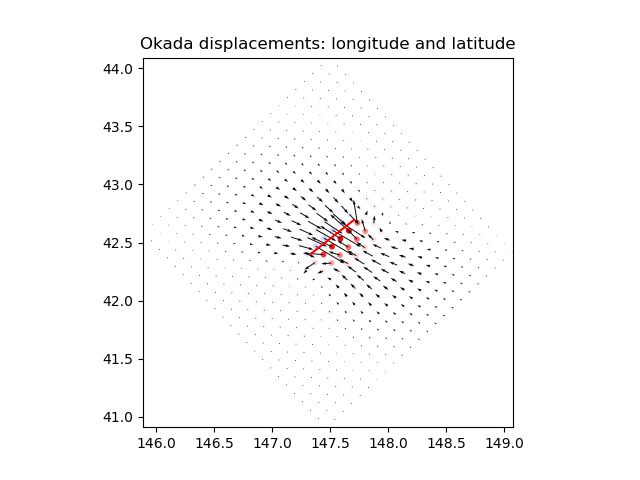

0.0
20000.0


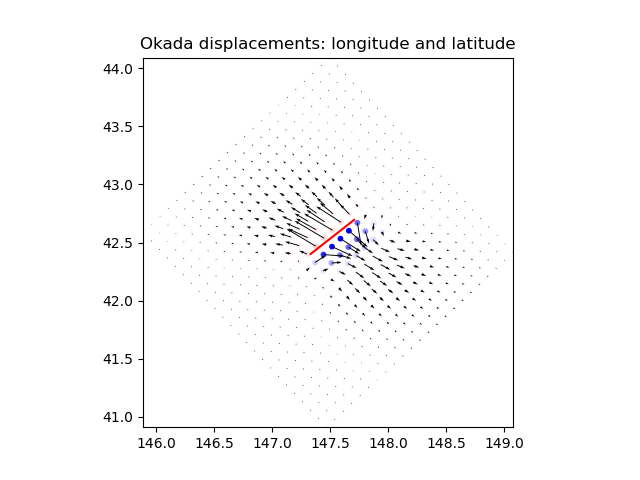

In [7]:
# dip-slip
celeri.plot_segment_displacements(
    this_segment,
    gridsta,
    command,
    segment_idx=0,
    strike_slip=0,
    dip_slip=1,
    tensile_slip=0,
    lon_min=np.min(gridsta.lon),
    lon_max=np.max(gridsta.lon),
    lat_min=np.min(gridsta.lat),
    lat_max=np.max(gridsta.lat),
    quiver_scale=1e0,
)
# dip-slip
celeri.plot_segment_displacements(
    this_segment_flipped,
    gridsta,
    command,
    segment_idx=0,
    strike_slip=0,
    dip_slip=1,
    tensile_slip=0,
    lon_min=np.min(gridsta.lon),
    lon_max=np.max(gridsta.lon),
    lat_min=np.min(gridsta.lat),
    lat_max=np.max(gridsta.lat),
    quiver_scale=1e0,
)

In [ ]:
# tensile-slip
celeri.plot_segment_displacements(
    segment,
    station,
    command,
    segment_idx=SEGMENT_IDX,
    strike_slip=0,
    dip_slip=0,
    tensile_slip=1,
    lon_min=135,
    lon_max=155,
    lat_min=30,
    lat_max=50,
    quiver_scale=1e-1,
)

# Summary of Okada slip rate conventions:
- ## Locking depth is positive down  
| type | sign | interpretation |
| - | - | - |
| strike-slip | positive | left-lateral |
| strike-slip | negative | right-lateral |
| dip-slip | positive | convergence |
| dip-slip | negative | extension |
| tensile-slip | positive | extension |
| tensile-slip | negative | convergence |
- ## Note: The difference in sign for convergence and extension for dip-slip and tensile-slip is not idea but it seems consistent with Okada?  Should I change this so that it is more intiutive (e.g., positive numbers are always convergence) or leave as is for consistency with Okada?


# Now let's take a look at differential block velocities

In [ ]:
SEGMENT_IDX = 65
segment.dip.values[SEGMENT_IDX] = 45
segment.locking_depth.values[SEGMENT_IDX] = 50


assembly = addict.Dict()
operators = addict.Dict()
assembly = celeri.merge_geodetic_data(
    assembly, station, sar
)  # Not sure this work correctly
# operators.okada_segment_station = celeri.get_segment_station_operator_okada(segment, station, command)

# Build all linear kinematic operators
operators.block_rotation = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)
operators.global_float_block_rotation = celeri.get_rotation_to_velocities_partials(
    station, 1
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)

# TODO: Fix below
assembly, operators.slip_rate_constraints = celeri.slip_rate_constraints(
    assembly, segment, block, command
)
operators.slip_rate_segment_block = celeri.get_fault_slip_rate_partials(segment, block)
operators.block_strain_rate, strain_rate_block_idx = (
    celeri.get_strain_rate_centroid_operator(block, station, segment)
)
operators.mogi_station = celeri.get_mogi_operator(mogi, station, command)

# Get additional matrix shape information for assembly
assembly.index.sz_elastic = (
    operators.okada_segment_station.shape
)  # Not sure this is correct
assembly.index.sz_slip = (
    operators.slip_rate_segment_block.shape
)  # Not sure this is correct
assembly.index.sz_rotation = operators.block_rotation.shape  # Not sure this is correct
assembly = celeri.station_row_keep(assembly)  # Not sure this is correct

In [ ]:
# Rotations only - with JDF a priori and no global float
data_vector = np.zeros(
    2 * assembly.data.n_stations + 3 * assembly.data.n_block_constraints
)
data_vector[0 : 2 * assembly.data.n_stations] = celeri.interleave2(
    assembly.data.east_vel, assembly.data.north_vel
)

# Add block motion costraints to data vector
data_vector[
    2 * assembly.data.n_stations : 2 * assembly.data.n_stations
    + 3 * assembly.data.n_block_constraints
] = assembly.data.block_constraints
data_vector[
    2 * assembly.data.n_stations : 2 * assembly.data.n_stations
    + 3 * assembly.data.n_block_constraints
] = 0

operator = np.zeros(
    (
        2 * assembly.data.n_stations + 3 * assembly.data.n_block_constraints,
        3 * len(block),
    )
)
operator[0 : 2 * assembly.data.n_stations, :] = np.delete(
    operators.block_rotation, np.arange(2, operators.block_rotation.shape[0], 3), axis=0
)  # Delete up velocity partials
operator[
    2 * assembly.data.n_stations : 2 * assembly.data.n_stations
    + 3 * assembly.data.n_block_constraints,
    :,
] = operators.block_motion_constraints

estimation = addict.Dict()
state_vector = np.linalg.inv(operator.T @ operator) @ operator.T @ data_vector
estimation.predictions = operator @ state_vector
vel = estimation.predictions[0 : 2 * assembly.data.n_stations]
estimation.east_vel = vel[0::2]
estimation.north_vel = vel[1::2]
east_vel_rotation_only = vel[0::2]
north_vel_rotation_only = vel[1::2]

# Plot observed and estimated velocities
lon_min = 235
lon_max = 255
lat_min = 30
lat_max = 50
quiver_scale = 1e2
plt.figure()
for i in range(len(segment)):
    plt.plot(
        [segment.lon1[i], segment.lon2[i]],
        [segment.lat1[i], segment.lat2[i]],
        "-k",
        linewidth=0.5,
    )
# plt.quiver(station.lon, station.lat, station.east_vel, station.north_vel, scale=quiver_scale, scale_units="inches", color="g")
plt.quiver(
    station.lon,
    station.lat,
    estimation.east_vel,
    estimation.north_vel,
    scale=quiver_scale,
    scale_units="inches",
    color="r",
)
# plt.xlim([lon_min, lon_max])
# plt.ylim([lat_min, lat_max])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("observed and estimated velocities - block rotations only")
plt.show()

# Convert estimated block motions to fault slip rates

In [ ]:
estimated_slip_rates = operators.slip_rate_segment_block @ state_vector
estimated_strike_slip_rates = estimated_slip_rates[0::3]
estimated_dip_slip_rates = estimated_slip_rates[1::3]
estimated_tensile_slip_rates = estimated_slip_rates[2::3]

plt.figure(figsize=(12, 12))
for i in range(len(segment)):
    plt.plot(
        [segment.lon1[i], segment.lon2[i]],
        [segment.lat1[i], segment.lat2[i]],
        "-k",
        linewidth=0.5,
    )
    plt.text(
        segment.mid_lon_plate_carree[i],
        segment.mid_lat_plate_carree[i],
        f"{estimated_strike_slip_rates[i]:.1f}",
        color="r",
        clip_on=True,
        fontsize=6,
        horizontalalignment="center",
        verticalalignment="center",
    )
plt.xlim([lon_min, lon_max])
plt.ylim([lat_min, lat_max])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("strike-slip rates")
plt.show()


plt.figure(figsize=(12, 12))
for i in range(len(segment)):
    plt.plot(
        [segment.lon1[i], segment.lon2[i]],
        [segment.lat1[i], segment.lat2[i]],
        "-k",
        linewidth=0.5,
    )
    plt.text(
        segment.mid_lon_plate_carree[i],
        segment.mid_lat_plate_carree[i],
        f"{estimated_dip_slip_rates[i]:.1f}",
        color="r",
        clip_on=True,
        fontsize=6,
        horizontalalignment="center",
        verticalalignment="center",
    )
# plt.xlim([lon_min, lon_max])
# plt.ylim([lat_min, lat_max])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("dip-slip rates")
plt.show()


plt.figure(figsize=(12, 12))
for i in range(len(segment)):
    plt.plot(
        [segment.lon1[i], segment.lon2[i]],
        [segment.lat1[i], segment.lat2[i]],
        "-k",
        linewidth=0.5,
    )
    plt.text(
        segment.mid_lon_plate_carree[i],
        segment.mid_lat_plate_carree[i],
        f"{estimated_tensile_slip_rates[i]:.1f}",
        color="r",
        clip_on=True,
        fontsize=6,
        horizontalalignment="center",
        verticalalignment="center",
    )
# plt.xlim([lon_min, lon_max])
# plt.ylim([lat_min, lat_max])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("tensile-slip rates")
plt.show()

# Summary of differential block motion/slip rate conventions:
| type | sign | interpretation |
| - | - | - |
| strike-slip | positive | left-lateral |
| strike-slip | negative | right-lateral |
| dip-slip | positive | convergence |
| dip-slip | negative | extension |
| tensile-slip | positive | extension |
| tensile-slip | negative | convergence |

- ## Note: The difference in sign for convergence and extension for dip-slip and tensile-slip is not ideal but it seems consistent with Okada.  Should I change this so that it is more intiutive (e.g., positive numbers are always convergence) or leave as is for consistency with Okada?  To make the tensile slip rate consistent with Okada there is a scale_factor = -1 in celeri.get_fault_slip_rate_partials.